In [1]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. 生成数据并手动稀疏化
X_dense, y = make_classification(n_samples=1000, n_features=100, n_informative=10, random_state=42)
X = csr_matrix(X_dense * (abs(X_dense) > 0.6))  # 只保留较大的值
print(f"特征矩阵类型: {type(X)}")  # 输出: <class 'scipy.sparse._csr.csr_matrix'>
print(f"标签形状: {y.shape}")     # 输出: (1000,)

特征矩阵类型: <class 'scipy.sparse._csr.csr_matrix'>
标签形状: (1000,)


In [2]:
from sklearn.model_selection import train_test_split

# 划分训练集（80%）和测试集（20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"训练集形状: {X_train.shape}")  # 输出: (800, 100)
print(f"测试集形状: {X_test.shape}")   # 输出: (200, 100)

训练集形状: (800, 100)
测试集形状: (200, 100)


In [3]:
# 检查稀疏矩阵的非零元素比例
sparsity = 1 - X_train.nnz / (X_train.shape[0] * X_train.shape[1])
print(f"训练集稀疏度: {sparsity:.2%}")  # 输出示例: 89.00% （表示89%的值为0）

训练集稀疏度: 42.15%


In [5]:
import numpy as np
from my_xgboost import XGBoost
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
import time
import pandas as pd

X_train=X_train.toarray()
X_test=X_test.toarray()

# 定义你的XGBoost模型（强制使用稠密矩阵）
my_model = XGBoost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    eps=1e-2,
    objective='binaryclass',
    global_split=True
)

# 方法1：用均值填充稀疏位置（零值）
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 方法2：PCA降维预处理（需先填充零值）
pca = PCA(n_components=0.95)  # 保留95%方差
X_train_pca = pca.fit_transform(X_train_imputed)
X_test_pca = pca.transform(X_test_imputed)

# 方法3：直接训练（原始稀疏数据，以稠密矩阵形式输入）
X_train_raw = X_train.copy()  # 已经是稠密矩阵，但包含大量零值
X_test_raw = X_test.copy()

# 训练并对比三种方法
methods = {
    "Mean Imputation + XGBoost": (X_train_imputed, X_test_imputed),
    "PCA + XGBoost": (X_train_pca, X_test_pca),
    "Sparse aware + XGBoost": (X_train_raw, X_test_raw)
}

results = []
for name, (X_tr, X_te) in methods.items():
    start_time = time.time()
    model =XGBoost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    eps=1e-2,
    global_split=True,
    objective='binaryclass'
)  # 每次重新初始化模型（确保公平对比）
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_pred_proba = 1 / (1 + np.exp(-y_pred))
# 将概率转换为类别预测（默认阈值为0.5）
    y_pred_class = (y_pred_proba > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class, average='macro')
    time_cost = time.time() - start_time
    
    results.append({
        "Method": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Time (s)": time_cost
    })

# 打印结果
results_df = pd.DataFrame(results).set_index("Method")
print(results_df)

Training XGBoost: 100%|██████████████| 100/100 [elapsed: 00:10 remaining: 00:00]

                           Accuracy  F1 Score   Time (s)
Method                                                  
Mean Imputation + XGBoost     0.845  0.844903   9.785556
PCA + XGBoost                 0.820  0.819712   9.574044
Sparse aware + XGBoost        0.855  0.854909  10.124074


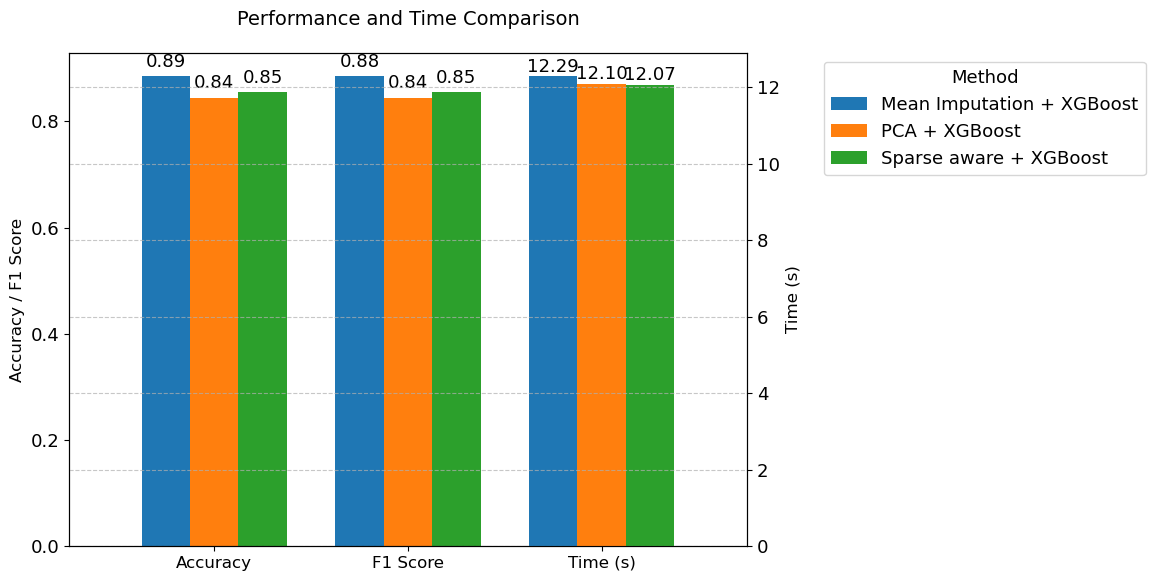

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 13})  # 基础字体从10→14

# 转换为长格式 DataFrame
df = pd.DataFrame(results)
df = df.melt(
    id_vars="Method",
    value_vars=["Accuracy", "F1 Score", "Time (s)"],
    var_name="Metric",
    value_name="Value"
)

# 设置颜色和参数
colors = {
    "Mean Imputation + XGBoost": "#1f77b4",
    "PCA + XGBoost": "#ff7f0e",
    "Sparse aware + XGBoost": "#2ca02c"
}
bar_width = 0.25
metrics = df["Metric"].unique()  # ["Accuracy", "F1 Score", "Time (s)"]
x = range(len(metrics))          # [0, 1, 2]

# 创建双 Y 轴画布
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()  # 共享X轴，独立Y轴

# 绘制 Accuracy 和 F1 Score（左侧 Y 轴）
for i, method in enumerate(colors.keys()):
    # 提取非时间指标数据
    non_time_data = df[(df["Method"] == method) & (df["Metric"] != "Time (s)")]
    # 计算位置
    x_pos = [pos + i * bar_width for pos in x[:-1]]  # 排除Time的位置（x=2）
    # 绘制柱状图
    ax1.bar(
        x_pos,
        non_time_data["Value"],
        width=bar_width,
        color=colors[method],
        label=method
    )
    # 添加数据标签
    for pos, value in zip(x_pos, non_time_data["Value"]):
        ax1.text(
            pos,
            value + 0.01,
            f"{value:.2f}",
            ha="center",
            va="bottom"
        )

# 绘制 Time (s)（右侧 Y 轴）
for i, method in enumerate(colors.keys()):
    # 提取时间数据
    time_data = df[(df["Method"] == method) & (df["Metric"] == "Time (s)")]
    # 计算位置（最后一个指标位置x=2）
    x_pos = 2 + i * bar_width
    # 绘制柱状图
    ax2.bar(
        x_pos,
        time_data["Value"],
        width=bar_width,
        color=colors[method],
        label=method
    )
    # 添加数据标签
    ax2.text(
        x_pos,
        time_data["Value"].values[0] + 0.01,
        f"{time_data['Value'].values[0]:.2f}",
        ha="center",
        va="bottom"
    )

# 自定义图形
ax1.set_xticks([pos + bar_width for pos in x])
ax1.set_xticklabels(metrics, fontsize=12)
ax1.set_ylabel("Accuracy / F1 Score", fontsize=12)
ax2.set_ylabel("Time (s)", fontsize=12)
ax1.set_title("Performance and Time Comparison", fontsize=14, pad=20)

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1, labels1, 
          title="Method", 
          bbox_to_anchor=(1.1, 1), 
          loc="upper left",
          )

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(-0.5, 3)
plt.tight_layout()
plt.show()